# Wine Quality Analysis

## Summary
`TODO`


## Introduction 
### (I) Background Introduction : 
This project explores the chemical properties of red and white "Vinho Verde" wine from north or Portugal. In this study, we aim to classify wine quality on a scale of 1–10 using a k-Nearest Neighbors (kNN) algorithm. This distance-based approach will allow us to predict the quality of a wine sample by comparing its physicochemical profile to similar observations in our training dataset.

`TODO: more background info on the topic and state the question we try to answer`

### (II) Data Description : 
The data is sourced from the UCI Machine Leaning Repository (CITATION).We will be working with the `winequality-red.csv` and `winequality-white.csv` dataset. `winequality-red.csv` contains 1599 observations and `winequality-white.csv` contains 4898 observations. Both datasets contain 12 variables including : 
- `fixed acidity` (dbl) - concentration of fixed acids in the wine
- `volatile acidity` (dbl) - amount of acetic acid, which can give a vinegar taste
- `citric acid` (dbl) – concentration of citric acid
- `residual sugar` (dbl) – amount of sugar remaining after fermentation
- `chlorides (dbl)` – salt content of the wine
- `free sulfur dioxide` (dbl) – free SO₂ level
- `total sulfur dioxide` (dbl) – total SO₂ level
- `density` (dbl) – density of the wine
- `pH` (dbl) – acidity level of the wine
- `sulphates` (dbl) – potassium sulphate level (wine preservative)
- `alcohol` (dbl) – alcohol percentage by volume
- `quality` (int) – quality score assigned to the wine with score of 1 to 10 (target variable) 


## Methods

### 1. Data Acquisition
The primary data source consists of two separate CSV files hosted on the UCI Machine Learning Repository, representing red and white wine samples. We begin by loading these files directly into our environment.

In [1]:
# load library and dataset 
import pandas as pd 

# load data from the original source on the web
red_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
white_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"

# the raw files use semicolons as delimiters
red = pd.read_csv(red_url, sep=";")
white = pd.read_csv(white_url, sep=";")

In [2]:
print(red.shape)
print(white.shape)

(1599, 12)
(4898, 12)


### 2. Data Cleaning and Standardization
To ensure the datasets can be merged and analyzed seamlessly, we standardize the column names. We convert all headers to lowercase and replace spaces with underscores to prevent syntax errors.

In [3]:
# clean column names
red.columns = red.columns.str.strip().str.lower().str.replace(" ", "_")
white.columns = white.columns.str.strip().str.lower().str.replace(" ", "_")

### 3. Data Integration 
Since we plan to analyze both wine types together, we preserve the identity of each observation before merging. We add a categorical column `wine_type` to each dataframe and then concatenate them into a single tidy dataset and saved to the processed data folder.

In [4]:
# add wine type labels
red["wine_type"] = "red"
white["wine_type"] = "white"

# merge the datasets
wine = pd.concat([red, white], ignore_index = True) 

# save to processed folder
wine.to_csv("data/processed/wine.csv", index= False)

In [5]:
wine.head().style.set_caption("Table 1: Combined Wine Dataset Preview")

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,wine_type
0,7.400000,0.700000,0.000000,1.900000,0.076000,11.000000,34.000000,0.997800,3.510000,0.560000,9.400000,5,red
1,7.800000,0.880000,0.000000,2.600000,0.098000,25.000000,67.000000,0.996800,3.200000,0.680000,9.800000,5,red
2,7.800000,0.760000,0.040000,2.300000,0.092000,15.000000,54.000000,0.997000,3.260000,0.650000,9.800000,5,red
3,11.200000,0.280000,0.560000,1.900000,0.075000,17.000000,60.000000,0.998000,3.160000,0.580000,9.800000,6,red
4,7.400000,0.700000,0.000000,1.900000,0.076000,11.000000,34.000000,0.997800,3.510000,0.560000,9.400000,5,red


Prior to partitioning the data, we verified the completeness of the dataset. As shown in the output below, there are no missing values across the 13 variables. This simplifies our pipeline as no imputation strategies are required to maintain data integrity.

In [14]:
# check for missing values to ensure the dataset is ready for machine learning
missing_values_table = wine.isnull().sum().to_frame(name="Missing Count")
missing_values_table.style.set_caption("Table 2: Missing Value Analysis")

,Missing Count
fixed_acidity,0
volatile_acidity,0
citric_acid,0
residual_sugar,0
chlorides,0
free_sulfur_dioxide,0
total_sulfur_dioxide,0
density,0
ph,0
sulphates,0


### 4. Data Partitioning (Train/Test Split)
To avoid data leakage and ensure we can evaluate our model's performance on unseen data, we split the data. We use a 70% training and 30% testing split. We also use stratification on the `quality` variable to ensure both sets have a similar distribution of quality scores.

In [15]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(
    wine,
    test_size=0.30,
    random_state=42,
    stratify=wine["quality"]
)

print(train.shape)
print(test.shape)

(4547, 13)
(1950, 13)


### 5. Exploratory Data Analysis (EDA)
With our training data isolated, we perform a summary analysis to understand the chemical difference between high-quality and low-quality wines.

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

First, we visualize the distribution of our target variable, `quality`, to check for class imbalances that might affect our classification results.

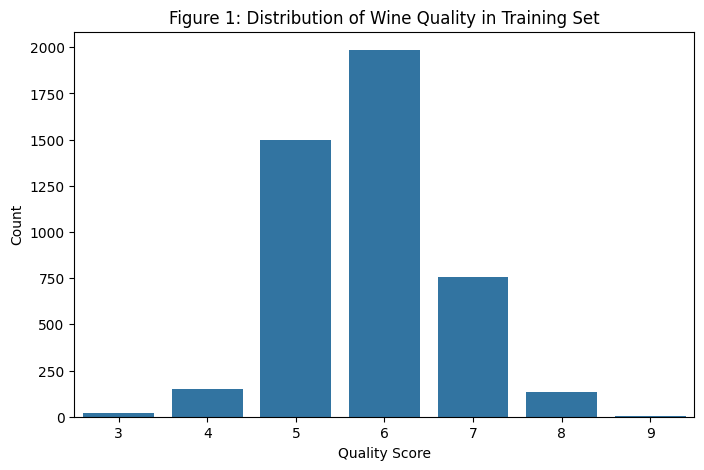

In [ ]:
# visualize the target variable
plt.figure(figsize=(8, 5))
sns.countplot(data=train, x="quality")
plt.title("Figure 1: Distribution of Wine Quality in Training Set")
plt.xlabel("Quality Score")
plt.ylabel("Count")
plt.show()

The historgram reveals that the majority of wines are rated as 5 or 6, while extreme values (3 or 9) are rare.

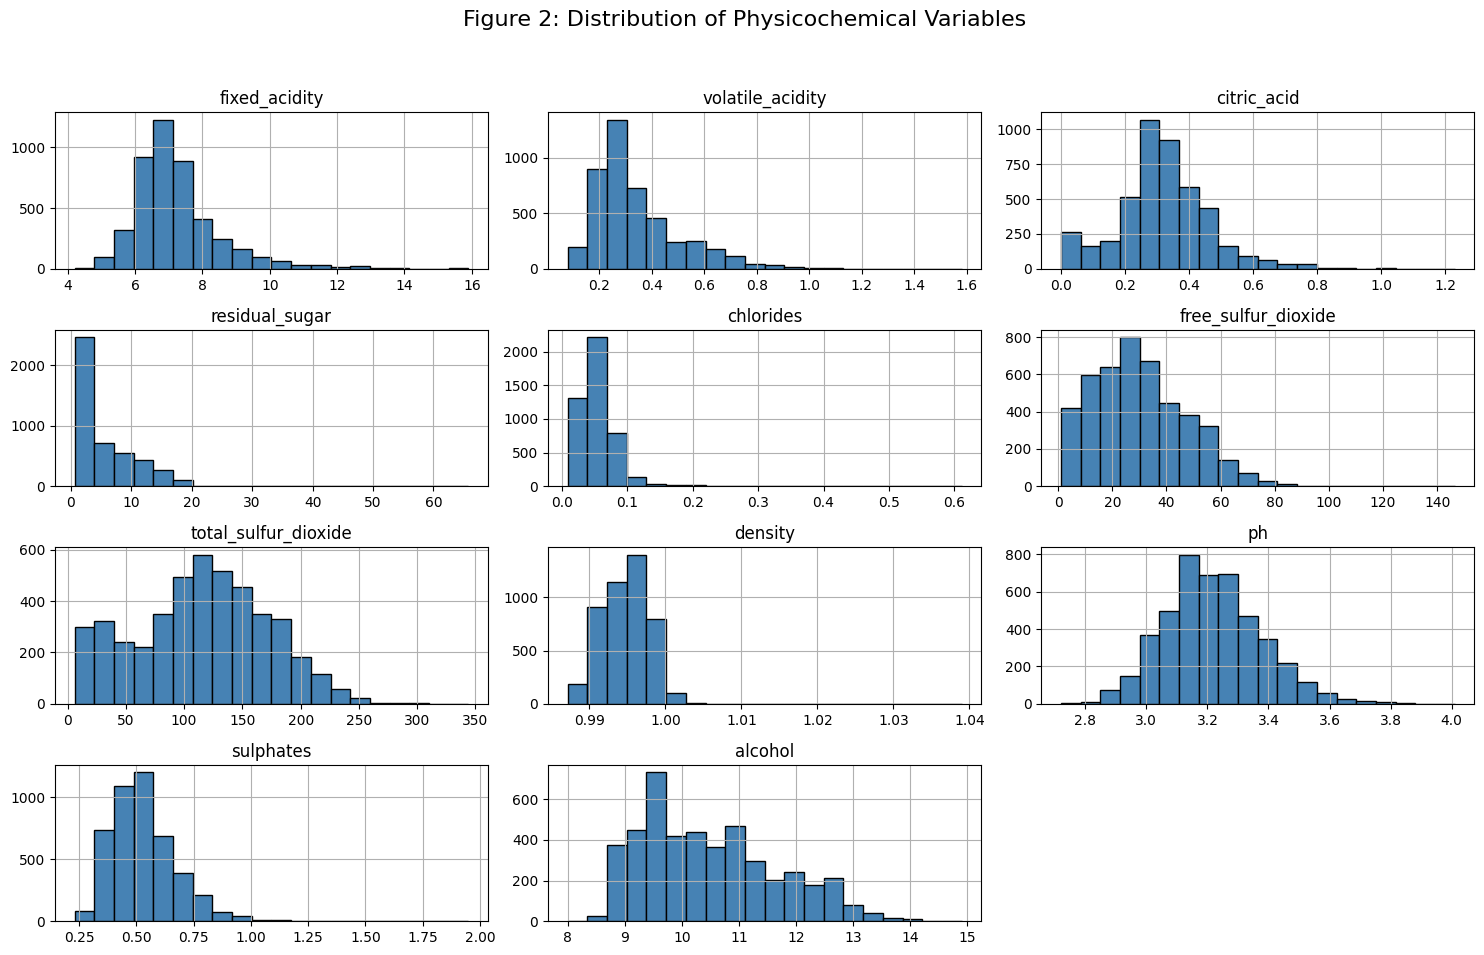

In [39]:
# distribution of all physicochemical features
# plot histograms for all numeric features to check for skewness
train.drop(columns='quality').hist(bins=20, figsize=(15, 10), color='steelblue', edgecolor='black')
plt.suptitle("Figure 2: Distribution of Physicochemical Variables", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In Figure 2, we visualized the distribution of all physicochemical features to assess skewness. While features like `pH` and `density` follow a relatively normal distribution, we observed significant right-skewness in `residual_sugar` and `clorides`. Additionally, we noted vastly different scales across variables (e.g., `total_sulfur_dioxide` vs. `density`), which could lead to biased results in a distance-based algorithm like kNN. These observations suggest that data transformation or feature scaling might be necessary to improve model performance

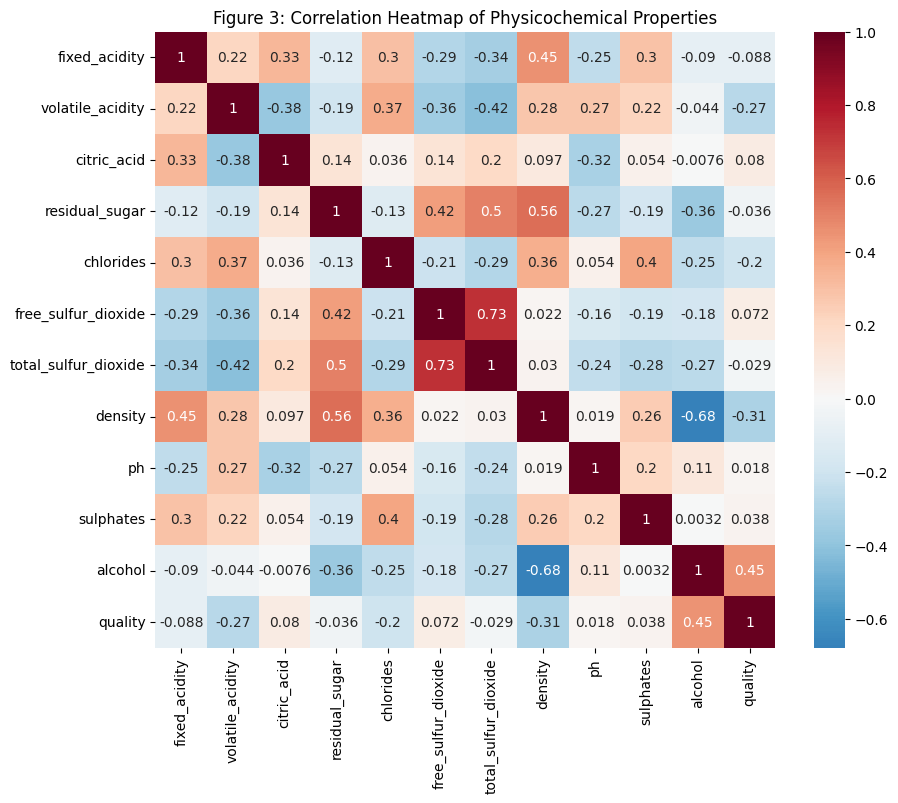

In [35]:
# calculate the correlation matrix to identify which features influence quality
plt.figure(figsize=(10, 8))
correlation_matrix = train.corr(numeric_only=True)

sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0)
plt.title("Figure 3: Correlation Heatmap of Physicochemical Properties")
plt.show()

To identify potential predictors for our classification model, we generated a correlation heatmap (Figure 3). This visualization shows that `alcohol` has the strongest positive correlation with quality, while `volatile acidity` shows notable nagative correlations.

In [31]:
# summary statistics for key chemical features
eda_summary = train.groupby("quality").mean(numeric_only=True)
eda_summary.style.set_caption("Table 3: Mean Chemical Properties by Quality Score")

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol
quality,,,,,,,,,,,
3,7.990476,0.545000,0.303810,4.619048,0.078667,24.738095,95.357143,0.995865,3.271429,0.499048,10.169048
4,7.362252,0.441026,0.280861,4.497020,0.058603,20.874172,105.917219,0.994999,3.227285,0.496887,10.112252
5,7.355481,0.396484,0.306130,5.789071,0.065277,30.301136,120.064505,0.995921,3.212941,0.528249,9.827137
6,7.212040,0.313685,0.323184,5.602821,0.054253,31.066751,114.730227,0.994640,3.217693,0.535199,10.577204
7,7.133444,0.286185,0.335311,4.719205,0.045535,30.576159,108.654967,0.993153,3.227947,0.547881,11.359832
8,6.785185,0.290333,0.325037,5.516667,0.040644,35.155556,121.155556,0.992439,3.220222,0.503481,11.674815
9,7.425000,0.312500,0.392500,4.650000,0.026500,35.000000,110.250000,0.991688,3.315000,0.462500,12.100000


This table summarizes how features like `alcohol` and `volatile_acidity` change as the quality score increases.

Since alcohol and acidity seem important, we look at them more closely across different quality levels.

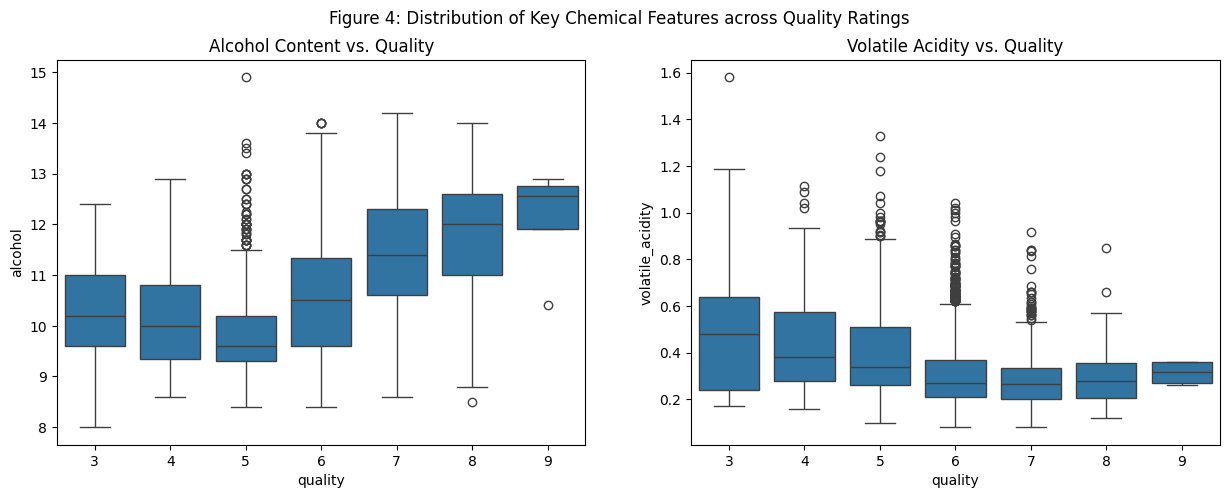

In [38]:
# visualize feature distribution by quality
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# alcohol vs quality
sns.boxplot(data=train, x='quality', y='alcohol', ax=axes[0])
axes[0].set_title("Alcohol Content vs. Quality")

# volatile Acidity vs quality
sns.boxplot(data=train, x='quality', y='volatile_acidity', ax=axes[1])
axes[1].set_title("Volatile Acidity vs. Quality")

plt.suptitle("Figure 4: Distribution of Key Chemical Features across Quality Ratings")
plt.show()

Figure 4 illustrates the relationship between quality and our key chemical features. We observe there is a general upward trend in alcohol content as quality improves. Similarly, volatile acidity shows an overall downward trajectory as quality increases.

In summary, our exploratory analysis confirms that while no single physicochemical property perfectly separates the wine quality ratings, distinct patterns exist in features like `alcohol` and `volatile_acidity`.

Although the correlation heatmap (Figure 3) reveals that some variables have weaker linear relationships with the target, we have elected to retain the full set of 11 features for the initial classification phase. This approach ensures that the kNN algorithm can leverage the high-dimensional neighborhoods of the data, capturing complex multivariate interactions that simple pairwise correlations might miss.

However, given the significant disparities in feature scales identified in our histograms (Figure 2), standardization (Z-score scaling) will be a mandatory step in the modeling pipeline to ensure that distance-based calculations are not biased by the magnitude of individual variables. The dataset is now cleaned, verified for integrity, and prepared for the training of our kNN classifier

### 6. kNN analysis

### 7. Model evaluation

## Results
TODO

## Discussion
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

## References
at least 4 citations